# Rewards and Utilities

The key distinction between control theory and reinforcement learning (RL) lies in the challenge of determining optimal actions without prior knowledge of what constitutes an optimal action. This contrasts with supervised learning, where we typically have access to a dataset of input-output pairs from an unknown mapping that we aim to approximate. While historical data might be available in RL, it often provides only indirect information about the right action to take in any given situation. This weaker form of supervisory feedback is typically provided via a reward function, which indicates the degree of adequacy for an action in the immediate situation. The reward function need not carry information about the long-term adequacy of an action towards achieving a more general objective, nor does it dictate the right action to take directly.

One might ask why we don't simply ask experts to provide this information more directly; that is, to provide examples of the right actions to choose in a given situation, hoping to generalize beyond those examples. While conceptually similar to supervised learning, this approach, called imitation learning (IL), still faces significant challenges as it offloads the burden of providing optimal solutions onto the expert. The complexity arises because we aim to find sequences of actions that maximize some long-term function of the rewards encountered along the way. Our decisions are rarely myopic, and it's this need for foresight in selecting actions that makes the problem challenging. Furthermore, significant challenges arise regarding whether the collected data is representative of the distribution of our current policy. This makes IL inherently bound to the challenge of out-of-distribution (OOD) generalization.

If providing examples of optimal actions is too difficult, it might be easier to let an algorithm search for those optimal actions while only specifying the goal that the system should achieve by defining a reward function. However, there are also instances where specifying the reward function itself could be a daunting task. The challenge lies in the fact that goals and objectives are usually temporally extended in nature, and that the consequences of actions compound through time, making it difficult to determine in advance the effect of local reward feedback on the overall solution found by the system.

## What is a good policy? 

Given access to data, we aim to determine the right actions or decisions to take in any given situation. However, to transform this aspiration into a concrete framework, we need to convert the notion of what constitutes a good way of acting—a policy—into an actionable definition. Furthermore, the adequacy of a policy is also a function of how it will be used—the environment to which it applies.

This course considers two broad categories of environments, each with its own specialized solution methods: deterministic and stochastic environments. Stochastic problems are mathematically more general than their deterministic counterparts, hence we begin our presentation with this setting. However, despite this generality, it's important to note that algorithms for stochastic problems are not necessarily more powerful than those designed for deterministic ones when used in practice. Stochasticity and determinism are assumed properties of the world, which we model—perhaps imperfectly—into our algorithms. Consequently, mathematical expressivity need not correlate with the empirical performance of a method. 

Seeking a good, adequate, performing, or optimal policy implies a notion of comparison. This necessitates a concept of ordering or ranking alternatives or choices from which one can select. In the deterministic setting, the outcome of an action is always the same and makes the problem of comparing alternatives slightly easier than in the stochastic case. Fortunately, there exists numerous mathematical concepts allowing us to compare random variables. We start with the notion of {term}`stochastic dominance` in probability theory. 

````{prf:definition}
:label: stochastic-ordering-scalar

Let $U$ and $V$ be scalar-valued random variables. We say that $U$ is stochastically greater than (or first-order stochastically dominates) $V$ if
$\text{Pr}[U > x] \geq \text{Pr}[V > x]$ for all $x \in \mathbb{R}$.
````

In one dimension, the concept of one distribution dominating another is straightforward and leads to a total ordering.

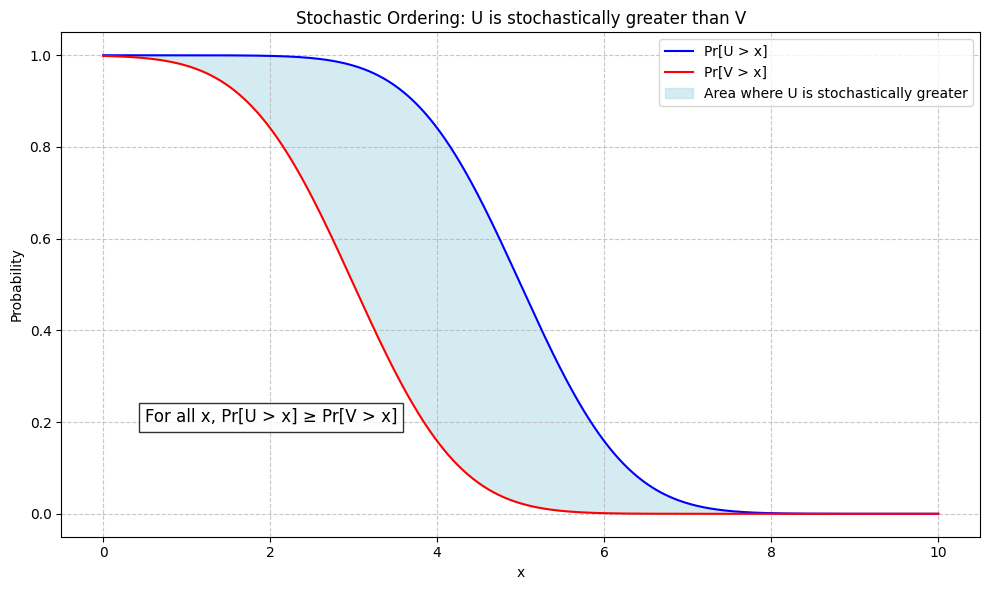

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Set random seed for reproducibility
np.random.seed(42)

# Generate two different normal distributions
mu1, sigma1 = 5, 1  # Mean and standard deviation for U
mu2, sigma2 = 3, 1  # Mean and standard deviation for V

# Create x values
x = np.linspace(0, 10, 1000)

# Calculate CDFs
cdf_U = stats.norm.cdf(x, mu1, sigma1)
cdf_V = stats.norm.cdf(x, mu2, sigma2)

# Calculate complementary CDFs (1 - CDF)
ccdf_U = 1 - cdf_U
ccdf_V = 1 - cdf_V

# Create the plot
plt.figure(figsize=(10, 6))

# Plot complementary CDFs
plt.plot(x, ccdf_U, label='Pr[U > x]', color='blue')
plt.plot(x, ccdf_V, label='Pr[V > x]', color='red')

# Fill the area where U is stochastically greater
plt.fill_between(x, ccdf_U, ccdf_V, where=(ccdf_U >= ccdf_V), 
                 color='lightblue', alpha=0.5, 
                 label='Area where U is stochastically greater')

plt.title('Stochastic Ordering: U is stochastically greater than V')
plt.xlabel('x')
plt.ylabel('Probability')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Add text explanation
plt.text(0.5, 0.2, 'For all x, Pr[U > x] ≥ Pr[V > x]', 
         fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

In higher dimensions, first-order stochastic dominance needs to account for all marginal distributions and their joint relationships, which can be difficult to verify directly. We can generalize the above definition to multivariate random variables as follows:

````{prf:definition}
:label: stochastic-ordering-multivariate

Let $\mathbf{U} = (U_1, \ldots, U_n)$ and $\mathbf{V} = (V_1, \ldots, V_n)$ be random vectors in $\mathbb{R}^n$. We say that $\mathbf{U}$ is stochastically greater than $\mathbf{V}$ if

$$
\mathbb{E}\left[f\left(\mathbf{V}\right)\right] \leq \mathbb{E}\left[f\left(\mathbf{U}\right)\right]
$$

 {u}`for all increasing functions $f`: \mathbb{R}^n \rightarrow \mathbb{R}$ with respect to the componentwise ordering, provided the expectations exist.
````
Here, a function $f$ is increasing with respect to the componentwise ordering if $\mathbf{x} \leq \mathbf{y}$ implies $f(\mathbf{x}) \leq f(\mathbf{y})$ for all $\mathbf{x}, \mathbf{y} \in \mathbb{R}^n$.
Note that in the scalar case ($n = 1$), the multivariate definition reduces to the scalar definition. To better understand this definition, let's attempt to turn it into an experiment. Let the random vectors $\mathbf{U} = (U_1, U_2)$ and $\mathbf{V} = (V_1, V_2)$ follow a bivariate normal distributions: $\mathbf{U} \sim \mathcal{N}(\boldsymbol{\mu}_U, \boldsymbol{\Sigma}_U)$ and $\mathbf{V} \sim \mathcal{N}(\boldsymbol{\mu}_V, \boldsymbol{\Sigma}_V)$ where $\boldsymbol{\mu}_U = \begin{pmatrix} 5 \\ 5 \end{pmatrix}$, $\boldsymbol{\mu}_V = \begin{pmatrix} 3 \\ 3 \end{pmatrix}$ and $\boldsymbol{\Sigma}_U = \boldsymbol{\Sigma}_V = \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix}$. The probability density function for a bivariate normal distribution is given by:

$$f(\mathbf{x}; \boldsymbol{\mu}, \boldsymbol{\Sigma}) = \frac{1}{2\pi|\boldsymbol{\Sigma}|^{1/2}} \exp\left(-\frac{1}{2}(\mathbf{x} - \boldsymbol{\mu})^T \boldsymbol{\Sigma}^{-1} (\mathbf{x} - \boldsymbol{\mu})\right)$$

where $\mathbf{x} = (x_1, x_2)^T$, $\boldsymbol{\mu}$ is the mean vector, and $\boldsymbol{\Sigma}$ is the covariance matrix. In our experiment, we generate increasing functions $f: \mathbb{R}^2 \to \mathbb{R}$ of the form:

$$f(\mathbf{x}) = ax_1 + bx_2 + c\sqrt{x_1^2 + x_2^2}$$

where $a$, $b$, and $c$ are non-negative random coefficients, and we compute $\mathbb{E}[f(\mathbf{U})]$ and $\mathbb{E}[f(\mathbf{V})]$ analytically.



The set of all possible increasing functions of course cannot be enumerated explicitely in our code. Therefore, we won't be able to programmatically verify stochastic dominance through this definition. But for the sake of building intuition, let's draw a function from the class of increasing function chosen above, compute the the corresponding expectations analytically.  


`````{admonition} Mathematical details
:class: dropdown

To compute $\mathbb{E}[f(\mathbf{U})]$, we use the linearity of expectation and the properties of the normal distribution:

1. $\mathbb{E}[aU_1 + bU_2] = a\mathbb{E}[U_1] + b\mathbb{E}[U_2] = (a+b)\mu_U$

2. For the term $c\sqrt{U_1^2 + U_2^2}$, we note that $U_1^2 + U_2^2$ follows a non-central chi-square distribution with 2 degrees of freedom and non-centrality parameter $\lambda = \frac{\mu_U^2}{\sigma^2}$. The expectation of the square root of this distribution is:

   $\mathbb{E}[\sqrt{U_1^2 + U_2^2}] = \sqrt{2}\sigma \cdot \frac{\Gamma(3/2)}{\Gamma(1)} \cdot {}_1F_1(-1/2; 1; -\lambda/2)$

   where ${}_1F_1$ is the confluent hypergeometric function. This can be simplified to:

   $\mathbb{E}[\sqrt{U_1^2 + U_2^2}] = \sqrt{2}\sqrt{\mu_U^2 + \sigma^2}$

Therefore, 

$\mathbb{E}[f(\mathbf{U})] = (a+b)\mu_U + c\sqrt{2}\sqrt{\mu_U^2 + \sigma^2}$
`````

We then get the following figure showing that for that one function which

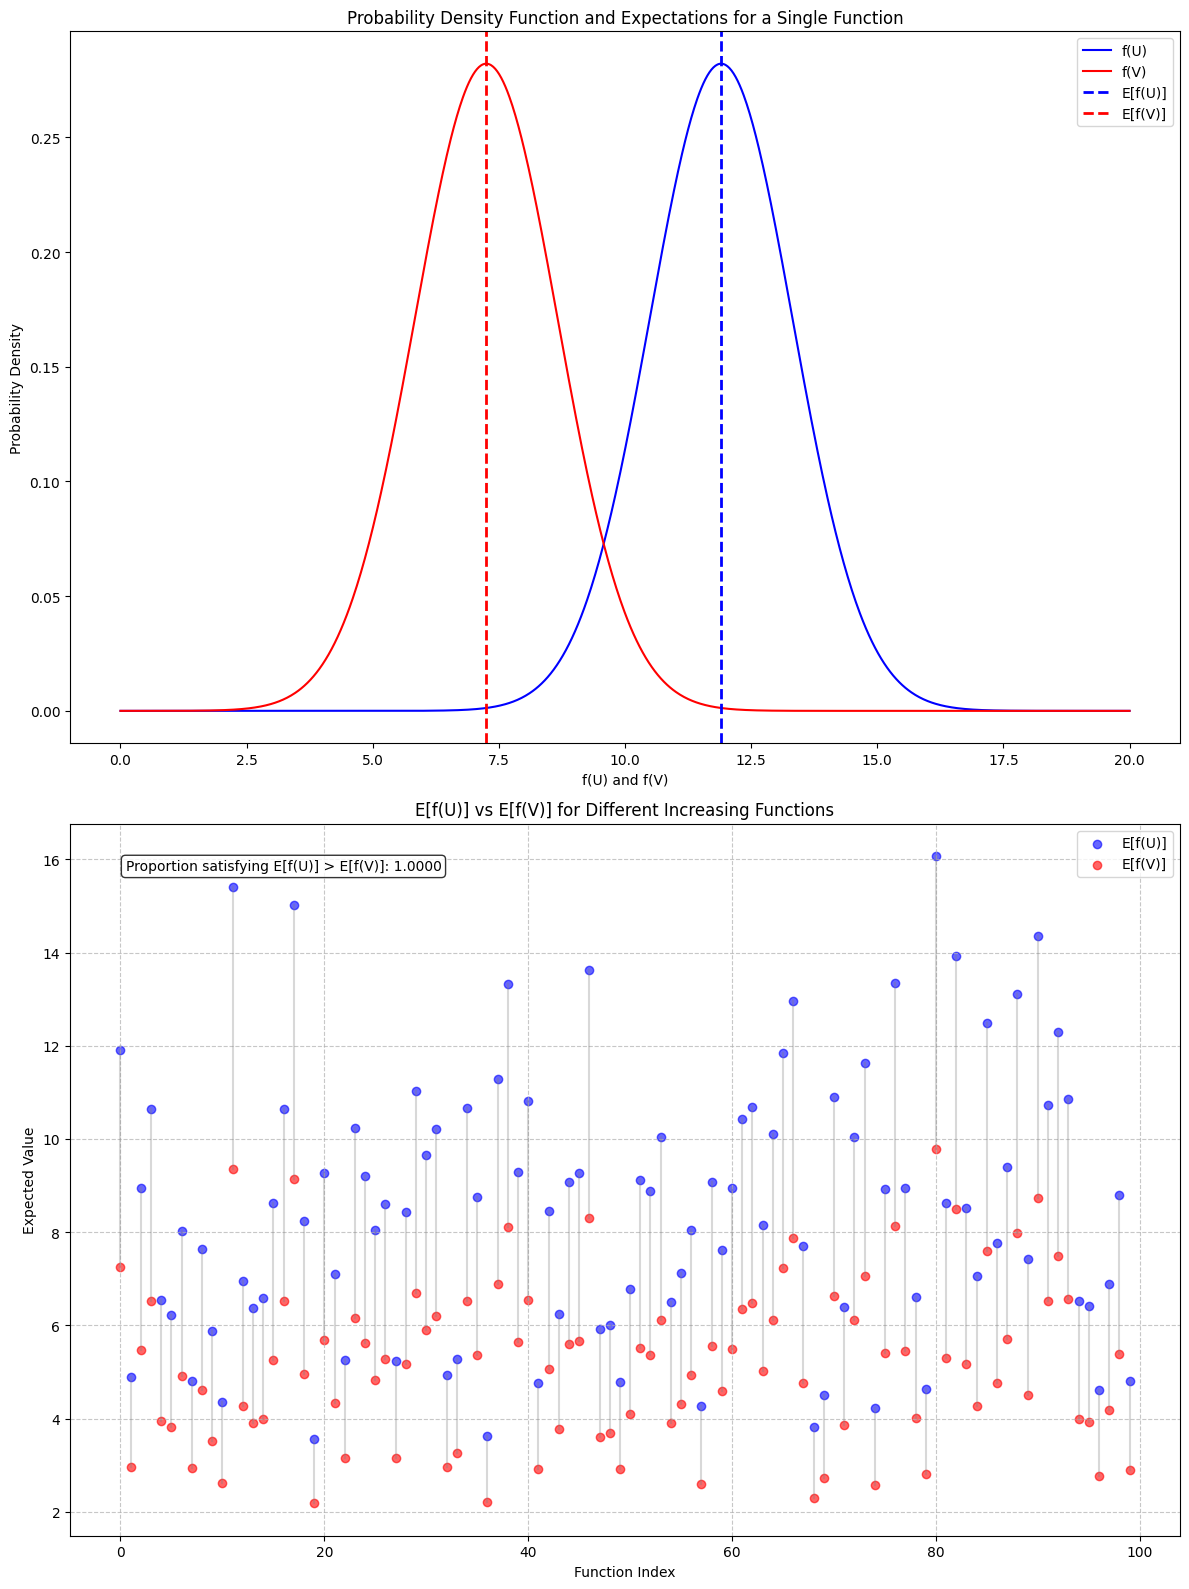

Proportion of functions satisfying E[f(U)] > E[f(V)]: 1.0000


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Parameters
mu_U, sigma_U = 5, 1
mu_V, sigma_V = 3, 1
n_functions = 100

def generate_increasing_function():
    a = np.random.rand()
    b = np.random.rand()
    c = np.random.rand()
    return lambda x, y: a * x + b * y + c * np.sqrt(x**2 + y**2), (a, b, c)

def analytical_expectation(mu, sigma, a, b, c):
    return (a + b) * mu + c * np.sqrt(2) * np.sqrt(mu**2 + sigma**2)

E_f_U_values = []
E_f_V_values = []

np.random.seed(42)
for _ in range(n_functions):
    f, (a, b, c) = generate_increasing_function()
    
    E_f_U = analytical_expectation(mu_U, sigma_U, a, b, c)
    E_f_V = analytical_expectation(mu_V, sigma_V, a, b, c)
    
    E_f_U_values.append(E_f_U)
    E_f_V_values.append(E_f_V)

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16))

# Subplot 1: PDF of a single function
x = np.linspace(0, 20, 1000)
f, (a, b, c) = generate_increasing_function()
pdf_U = stats.norm.pdf(x, E_f_U_values[0], np.sqrt(2) * sigma_U)
pdf_V = stats.norm.pdf(x, E_f_V_values[0], np.sqrt(2) * sigma_V)

ax1.plot(x, pdf_U, color='blue', label='f(U)')
ax1.plot(x, pdf_V, color='red', label='f(V)')
ax1.axvline(E_f_U_values[0], color='blue', linestyle='dashed', linewidth=2, label='E[f(U)]')
ax1.axvline(E_f_V_values[0], color='red', linestyle='dashed', linewidth=2, label='E[f(V)]')

ax1.set_title('Probability Density Function and Expectations for a Single Function')
ax1.set_xlabel('f(U) and f(V)')
ax1.set_ylabel('Probability Density')
ax1.legend()

# Subplot 2: Scatter plot for multiple functions
ax2.scatter(range(n_functions), E_f_U_values, color='blue', alpha=0.6, label='E[f(U)]')
ax2.scatter(range(n_functions), E_f_V_values, color='red', alpha=0.6, label='E[f(V)]')

for i in range(n_functions):
    ax2.plot([i, i], [E_f_V_values[i], E_f_U_values[i]], color='gray', alpha=0.3)

ax2.set_title('E[f(U)] vs E[f(V)] for Different Increasing Functions')
ax2.set_xlabel('Function Index')
ax2.set_ylabel('Expected Value')
ax2.legend()

proportion_satisfied = np.mean(np.array(E_f_U_values) > np.array(E_f_V_values))
ax2.text(0.05, 0.95, f'Proportion satisfying E[f(U)] > E[f(V)]: {proportion_satisfied:.4f}', 
         transform=ax2.transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax2.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

print(f"Proportion of functions satisfying E[f(U)] > E[f(V)]: {proportion_satisfied:.4f}")

<!-- 
Our experiment has shown that of all the random functions drawn from our family of increasing functions, $\mathbb{E}[f(\mathbf{U})] \geq \mathbb{E}[f(\mathbf{U})]$. But is that enough for establishing stochastic dominance? We could try the same experiment for more increasing functions, but what if we still observe that 100% of the samples satisfy the inequality? For this particular example with normal distribution with the same variance, 

To prove that $\mathbf{U}$ stochastically dominates $\mathbf{V}$, we need to show that for any increasing function $f: \mathbb{R}^2 \rightarrow \mathbb{R}$, we have $\mathbb{E}[f(\mathbf{U})] \geq \mathbb{E}[f(\mathbf{V})]$.

Proof:

1. First, note that $\mathbf{U}$ can be expressed as $\mathbf{U} = \mathbf{V} + \mathbf{W}$, where $\mathbf{W} = (W_1, W_2) \sim \mathcal{N}((2, 2)^T, \mathbf{0})$ and is independent of $\mathbf{V}$. This is because the difference of their means is (2, 2) and their covariance matrices are identical.

2. Now, for any increasing function $f$, we have:

   $f(\mathbf{U}) = f(\mathbf{V} + \mathbf{W}) \geq f(\mathbf{V})$ (pointwise)

   This is because $\mathbf{W}$ is non-negative with probability 1, and $f$ is increasing.

3. Taking expectations of both sides:

   $\mathbb{E}[f(\mathbf{U})] = \mathbb{E}[f(\mathbf{V} + \mathbf{W})] \geq \mathbb{E}[f(\mathbf{V})]$

The equality holds because expectation is linear, and the inequality holds because expectation preserves inequalities. Since this is true for any increasing function $f$, we have proven that $\mathbf{U}$ stochastically dominates $\mathbf{V}$. -->